## 1. Setup & Data Download

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from hashlib import sha1
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
import torchvision.models as models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU: Tesla T4


In [2]:
# Configuration
DATA_DIR = 'data'
IMAGES_DIR = os.path.join(DATA_DIR, 'Images')
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions.csv')
MODELS_DIR = 'models'

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Hyperparameters (adjusted to reduce overfitting)
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 3e-4
MIN_WORD_FREQ = 5      # Words appearing less than this are replaced with <UNK>
DROPOUT = 0.6
EARLY_STOP_PATIENCE = 3  # Stop if no improvement for 3 epochs

In [3]:
def download_flickr8k():
    """Download Flickr8k from Hugging Face and save images + captions locally."""

    # Quick check if already done
    if os.path.exists(CAPTIONS_FILE) and len(os.listdir(IMAGES_DIR)) > 7000:
        print('Dataset appears to be already downloaded!')
        return

    print('Downloading Flickr8k dataset from Hugging Face...')
    dataset = load_dataset('jxie/flickr8k')

    captions_data = []

    # Usually only one split exists ('train'), but loop in case structure changes
    for split in dataset.keys():
        print(f'Processing {split} split...')
        for item in tqdm(dataset[split], desc=split):
            # Get the PIL image
            img: Image.Image = item['image']

            img_bytes = img.tobytes()
            img_filename = sha1(img_bytes).hexdigest()[:16] + ".jpg"

            img_path = os.path.join(IMAGES_DIR, img_filename)

            # Save image only if not already present
            if not os.path.exists(img_path):
                img.save(img_path)

            # Collect all 5 captions
            for i in range(5):
                caption_key = f'caption_{i}'
                if caption_key in item and item[caption_key]:
                    captions_data.append({
                        'image': img_filename,
                        'caption': item[caption_key]
                    })

    # Save to CSV (one row per image-caption pair → ~40,000 rows)
    df = pd.DataFrame(captions_data)
    df.to_csv(CAPTIONS_FILE, index=False)

    print(f'\nDownload complete!')
    print(f'Images saved: {len(os.listdir(IMAGES_DIR))}')
    print(f'Captions saved: {len(df)} (≈ {len(df)//5} unique images)')

# Run it
download_flickr8k()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/687 [00:00<?, ?B/s]

data/train-00000-of-00002-2f8f6bfa852eac(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/train-00001-of-00002-2173151d8cd6c7(…):   0%|          | 0.00/414M [00:00<?, ?B/s]

data/validation-00000-of-00001-7025a2b59(…):   0%|          | 0.00/138M [00:00<?, ?B/s]

data/test-00000-of-00001-42a2661d12c73e4(…):   0%|          | 0.00/137M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Processing train split...


train: 100%|██████████| 6000/6000 [00:30<00:00, 198.82it/s]


Processing validation split...


validation: 100%|██████████| 1000/1000 [00:04<00:00, 222.73it/s]


Processing test split...


test: 100%|██████████| 1000/1000 [00:04<00:00, 223.48it/s]



Download complete!
Images saved: 7999
Captions saved: 40000 (≈ 8000 unique images)


## 2. Data Preprocessing

In [4]:
# Load captions data
df = pd.read_csv(CAPTIONS_FILE)
print(f'Total caption entries: {len(df)}')
print(f'Unique images: {df["image"].nunique()}')
print(f'\nSample data:')
df.head(10)

Total caption entries: 40000
Unique images: 7999

Sample data:


,image,caption
0,6c57aca59aaf2309.jpg,A black dog is running after a white dog in th...
1,6c57aca59aaf2309.jpg,Black dog chasing brown dog through snow
2,6c57aca59aaf2309.jpg,Two dogs chase each other across the snowy gro...
3,6c57aca59aaf2309.jpg,Two dogs play together in the snow .
4,6c57aca59aaf2309.jpg,Two dogs running through a low lying body of w...
5,30d9a5bfef410681.jpg,A little baby plays croquet .
6,30d9a5bfef410681.jpg,A little girl plays croquet next to a truck .
7,30d9a5bfef410681.jpg,The child is playing croquette by the truck .
8,30d9a5bfef410681.jpg,The kid is in front of a car with a put and a ...
9,30d9a5bfef410681.jpg,The little boy is playing with a croquet hamme...


In [5]:
# Clean captions
def clean_caption(caption):
    """Clean and preprocess caption text."""
    caption = str(caption).lower()
    caption = ''.join(c for c in caption if c.isalpha() or c.isspace())
    caption = ' '.join(caption.split())  # Remove extra spaces
    return caption

df['cleaned_caption'] = df['caption'].apply(clean_caption)
print('Cleaned captions sample:')
df[['caption', 'cleaned_caption']].head()

Cleaned captions sample:


,caption,cleaned_caption
0,A black dog is running after a white dog in th...,a black dog is running after a white dog in th...
1,Black dog chasing brown dog through snow,black dog chasing brown dog through snow
2,Two dogs chase each other across the snowy gro...,two dogs chase each other across the snowy ground
3,Two dogs play together in the snow .,two dogs play together in the snow
4,Two dogs running through a low lying body of w...,two dogs running through a low lying body of w...


In [6]:
class Vocabulary:
    """Vocabulary class for mapping words to indices and vice versa."""

    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()

        # Special tokens
        self.pad_token = '<PAD>'
        self.start_token = '<START>'
        self.end_token = '<END>'
        self.unk_token = '<UNK>'

    def build_vocabulary(self, captions):
        """Build vocabulary from list of captions."""
        # Count word frequencies
        for caption in captions:
            for word in str(caption).split():
                self.word_freq[word] += 1

        # Add special tokens
        for idx, token in enumerate([self.pad_token, self.start_token, self.end_token, self.unk_token]):
            self.word2idx[token] = idx
            self.idx2word[idx] = token

        # Add words that meet minimum frequency
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f'Vocabulary size: {len(self.word2idx)}')
        print(f'Words below min_freq ({self.min_freq}): {sum(1 for f in self.word_freq.values() if f < self.min_freq)}')

    def encode(self, caption):
        """Convert caption string to list of indices."""
        tokens = [self.word2idx[self.start_token]]
        for word in str(caption).split():
            tokens.append(self.word2idx.get(word, self.word2idx[self.unk_token]))
        tokens.append(self.word2idx[self.end_token])
        return tokens

    def decode(self, indices):
        """Convert list of indices back to caption string."""
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, self.unk_token)
            if word == self.end_token:
                break
            if word not in [self.start_token, self.pad_token]:
                words.append(word)
        return ' '.join(words)

    def __len__(self):
        return len(self.word2idx)

In [7]:
# Build vocabulary
vocab = Vocabulary(min_freq=MIN_WORD_FREQ)
vocab.build_vocabulary(df['cleaned_caption'].tolist())

# Test encoding/decoding
test_caption = df['cleaned_caption'].iloc[0]
print(f'\nOriginal: {test_caption}')
encoded = vocab.encode(test_caption)
print(f'Encoded: {encoded}')
decoded = vocab.decode(encoded)
print(f'Decoded: {decoded}')

Vocabulary size: 2950
Words below min_freq (5): 5727

Original: a black dog is running after a white dog in the snow
Encoded: [1, 4, 5, 6, 7, 8, 9, 4, 10, 6, 11, 12, 13, 2]
Decoded: a black dog is running after a white dog in the snow


In [8]:
# Train/validation split (90/10 by unique images)
unique_images = df['image'].unique()
np.random.shuffle(unique_images)

train_size = int(0.9 * len(unique_images))
train_images = set(unique_images[:train_size])
val_images = set(unique_images[train_size:])

train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
val_df = df[df['image'].isin(val_images)].reset_index(drop=True)

print(f'Training samples: {len(train_df)} ({len(train_images)} images)')
print(f'Validation samples: {len(val_df)} ({len(val_images)} images)')

Training samples: 36000 (7199 images)
Validation samples: 4000 (800 images)


In [9]:
class CaptionDataset(Dataset):
    """Custom Dataset for image captioning."""

    def __init__(self, dataframe, images_dir, vocab, transform=None):
        self.df = dataframe
        self.images_dir = images_dir
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and transform image
        img_path = os.path.join(self.images_dir, row['image'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Encode caption
        caption = self.vocab.encode(row['cleaned_caption'])
        caption = torch.tensor(caption, dtype=torch.long)

        return image, caption


def collate_fn(batch):
    """Custom collate function to pad captions to same length."""
    images, captions = zip(*batch)

    # Stack images
    images = torch.stack(images, dim=0)

    # Pad captions
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return images, captions

In [10]:
# Image transforms - with data augmentation for training to reduce overfitting
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize slightly larger
    transforms.RandomCrop(224),     # Random crop for augmentation
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation transform - no augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = CaptionDataset(train_df, IMAGES_DIR, vocab, train_transform)
val_dataset = CaptionDataset(val_df, IMAGES_DIR, vocab, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')

Train batches: 1125
Val batches: 125


## 3. Model Definition

In [11]:
class EncoderCNN(nn.Module):
    """CNN Encoder using pre-trained ResNet50."""

    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        # Load pre-trained ResNet50
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Remove the final classification layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Linear layer to project features to embed_size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):
        # Extract features
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)

        # Project to embedding space
        features = self.fc(features)
        features = self.bn(features)

        return features


class DecoderRNN(nn.Module):
    """LSTM Decoder for caption generation."""

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(DecoderRNN, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Word embedding layer with dropout
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.embed_dropout = nn.Dropout(dropout)  # Dropout on embeddings

        # LSTM
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        """
        Forward pass for training.
        features: (batch_size, embed_size) - encoded image features
        captions: (batch_size, seq_length) - target captions
        """
        # Embed captions (exclude last token for input)
        embeddings = self.embedding(captions[:, :-1])  # (batch, seq_len-1, embed_size)
        embeddings = self.embed_dropout(embeddings)    # Apply dropout to embeddings

        # Prepend image features as first input
        features = features.unsqueeze(1)  # (batch, 1, embed_size)
        embeddings = torch.cat([features, embeddings], dim=1)  # (batch, seq_len, embed_size)

        # LSTM forward pass
        lstm_out, _ = self.lstm(embeddings)
        lstm_out = self.dropout(lstm_out)

        # Output predictions
        outputs = self.fc(lstm_out)  # (batch, seq_len, vocab_size)

        return outputs

    def generate(self, features, max_length=30, temperature=1.0):
        """
        Generate caption for inference.
        features: (1, embed_size) - encoded image features
        """
        generated = []

        # Initialize hidden state
        h = torch.zeros(self.num_layers, 1, self.hidden_size).to(features.device)
        c = torch.zeros(self.num_layers, 1, self.hidden_size).to(features.device)

        # First input is image features
        x = features.unsqueeze(1)  # (1, 1, embed_size)

        for _ in range(max_length):
            lstm_out, (h, c) = self.lstm(x, (h, c))
            output = self.fc(lstm_out.squeeze(1))  # (1, vocab_size)

            # Apply temperature and get prediction
            output = output / temperature
            predicted = output.argmax(dim=1)

            generated.append(predicted.item())

            # Stop if END token
            if predicted.item() == 2:  # <END> token index
                break

            # Next input is predicted word
            x = self.embedding(predicted).unsqueeze(1)

        return generated


class ImageCaptioningModel(nn.Module):
    """Complete Image Captioning Model."""

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers, dropout)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, max_length=30, temperature=1.0):
        """Generate caption for a single image."""
        self.eval()
        with torch.no_grad():
            features = self.encoder(image)
            caption_indices = self.decoder.generate(features, max_length, temperature)
        return caption_indices

In [12]:
# Initialize model
model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=len(vocab),
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Print model summary
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


ImageCaptioningModel(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

## 4. Training

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for images, captions in progress_bar:
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        outputs = model(images, captions)

        # Calculate loss
        outputs = outputs.view(-1, outputs.size(-1))
        targets = captions.view(-1)

        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc='Validating'):
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions)

            outputs = outputs.view(-1, outputs.size(-1))
            targets = captions.view(-1)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print('Starting training...')
print('=' * 60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch + 1}/{NUM_EPOCHS}')

    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # Update learning rate
    scheduler.step()

    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, os.path.join(MODELS_DIR, 'best_model.pth'))
        print('  -> Best model saved!')
    else:
        patience_counter += 1
        print(f'  -> No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})')

        # Early stopping check
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f'\nEarly stopping triggered! No improvement for {EARLY_STOP_PATIENCE} epochs.')
            break

print('\n' + '=' * 60)
print('Training complete!')

Starting training...

Epoch 1/10


Validating: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Train Loss: 4.1455 | Val Loss: 3.5117
  -> Best model saved!

Epoch 2/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Train Loss: 3.4530 | Val Loss: 3.2137
  -> Best model saved!

Epoch 3/10


Validating: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Train Loss: 3.2323 | Val Loss: 3.0532
  -> Best model saved!

Epoch 4/10


Validating: 100%|██████████| 125/125 [00:18<00:00,  6.68it/s]


Train Loss: 3.0946 | Val Loss: 2.9520
  -> Best model saved!

Epoch 5/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


Train Loss: 2.9937 | Val Loss: 2.8784
  -> Best model saved!

Epoch 6/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]


Train Loss: 2.9115 | Val Loss: 2.8365
  -> Best model saved!

Epoch 7/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]


Train Loss: 2.8693 | Val Loss: 2.8073
  -> Best model saved!

Epoch 8/10


Validating: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Train Loss: 2.8352 | Val Loss: 2.7873
  -> Best model saved!

Epoch 9/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


Train Loss: 2.8033 | Val Loss: 2.7638
  -> Best model saved!

Epoch 10/10


Validating: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]


Train Loss: 2.7723 | Val Loss: 2.7456
  -> Best model saved!

Training complete!


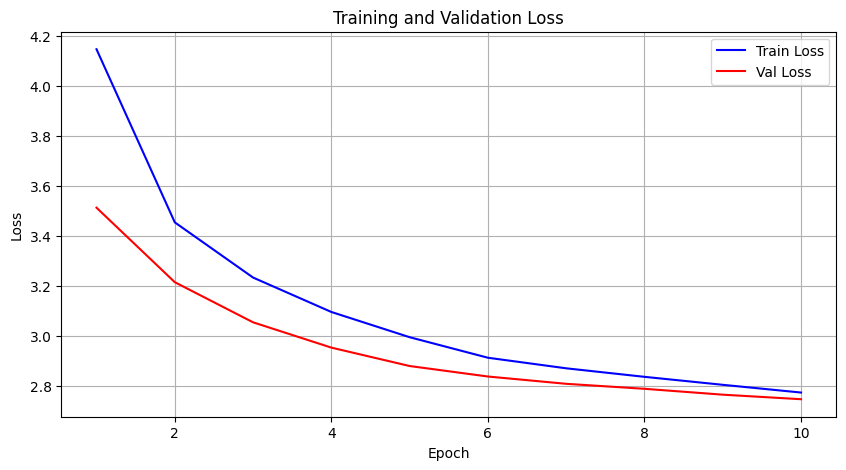

In [16]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(MODELS_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Model

In [17]:
# Save final model with all config
torch.save({
    'model_state_dict': model.state_dict(),
    'embed_size': EMBED_SIZE,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'vocab_size': len(vocab),
    'dropout': DROPOUT,
}, os.path.join(MODELS_DIR, 'final_model.pth'))

print(f'Final model saved to {MODELS_DIR}/final_model.pth')

Final model saved to models/final_model.pth


In [18]:
# Save vocabulary
vocab_data = {
    'word2idx': vocab.word2idx,
    'idx2word': vocab.idx2word,
    'min_freq': vocab.min_freq
}

with open(os.path.join(MODELS_DIR, 'vocab.pkl'), 'wb') as f:
    pickle.dump(vocab_data, f)

print(f'Vocabulary saved to {MODELS_DIR}/vocab.pkl')

Vocabulary saved to models/vocab.pkl


In [19]:
# Save validation image list for inference notebook
val_images_list = list(val_images)
with open(os.path.join(MODELS_DIR, 'val_images.pkl'), 'wb') as f:
    pickle.dump(val_images_list, f)

print(f'Validation images list saved ({len(val_images_list)} images)')

Validation images list saved (800 images)


In [20]:
print('\n' + '=' * 60)
print('All artifacts saved:')
print(f'  - {MODELS_DIR}/best_model.pth')
print(f'  - {MODELS_DIR}/final_model.pth')
print(f'  - {MODELS_DIR}/vocab.pkl')
print(f'  - {MODELS_DIR}/val_images.pkl')
print(f'  - {MODELS_DIR}/training_curves.png')
print('=' * 60)


All artifacts saved:
  - models/best_model.pth
  - models/final_model.pth
  - models/vocab.pkl
  - models/val_images.pkl
  - models/training_curves.png
